In [6]:
#pip install pingouin

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
import pingouin as pg
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
import os

In [2]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)

In [3]:
os.chdir('C:/Users/Ryo/OneDrive/Desktop/Master Thesis/master_thesis/study3')

# data preparation

## prep for the response df

In [4]:
file_loc = 'raw/Study3 - final_July_18_2024_02_35_final.xlsx'
df = pd.read_excel(file_loc)
df

,ResponseId,Ads_OP_1_Reversed,Ads_OP_2_Reversed,Ads_OP_3_Reversed,Ads_OP_4_Reversed,Ads_OP_5_Reversed,Ads_OP_6_Reversed,Ads_CO_1_Normal,Ads_CO_2_Normal,Ads_CO_3_Normal,Ads_CO_4_Normal,Ads_CO_5_Normal,Ads_CO_6_Normal,Ads_EX_1_Reversed,Ads_EX_2_Reversed,Ads_EX_3_Reversed,Ads_EX_4_Reversed,Ads_EX_5_Reversed,Ads_EX_6_Reversed,Ads_AG_1_Normal,Ads_AG_2_Normal,Ads_AG_3_Normal,Ads_AG_4_Normal,Ads_AG_5_Normal,Ads_AG_6_Normal,Desc_OP_1_Normal,Desc_CO_1_Reversed,Desc_EX_1_Normal,Desc_AG_1_Reversed
0,5db4f0b63e33f2000dd54016,22,19,14,16,17,15,21,22,18,18,18,15,24,25,23,22,21,17,70,69,69,68,65,61,75,26,75,22
1,66294a585f1cf3fdaeb80120,28,50,47,72,50,41,34,50,50,59,46,21,46,50,58,62,55,38,56,50,55,64,58,60,91,90,80,40
2,665a52573b9527ce0011158b,10,10,10,10,10,10,0,0,0,0,0,0,10,10,10,10,10,10,61,60,61,61,61,62,100,100,100,42
3,651ebcca48c60acc82f1f2bd,60,50,63,90,90,89,31,50,34,50,39,37,62,50,65,80,70,79,62,50,54,67,67,77,82,82,82,34
4,6634fb892af2e227ab65f004,80,50,90,85,90,85,80,50,75,50,75,87,95,50,95,50,95,95,70,60,70,67,70,70,10,80,60,80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,64d52f62a1f1a7371760fe4f,82,64,86,72,79,90,40,44,24,37,31,15,39,31,21,21,13,13,81,73,91,68,81,89,20,70,83,32
88,66622736b3fcb6b8f3c04fdd,88,86,92,83,86,85,28,41,11,28,28,16,81,78,87,81,75,86,68,66,70,61,70,66,76,26,68,30
89,6660680acd027329cecdf2b8,37,33,35,49,47,46,61,56,67,53,74,86,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
90,5d215a1bbf7f840019701939,53,52,70,62,75,82,35,49,28,40,31,33,69,69,77,64,69,68,53,54,55,51,50,50,51,52,53,53


In [18]:
print(f"shape {df.shape}")

shape (90, 29)


In [15]:
file_loc = 'raw/20240721_prolific_export.csv'
target_respondants = pd.read_csv(file_loc)
target_respondants = target_respondants[target_respondants['Status'] == 'APPROVED']['Participant id'].unique().tolist()
len(target_respondants)

90

In [17]:
study3_respondants = df['ResponseId'].tolist()
print(f"original respondse counts: {len(study3_respondants)}")

# filter df to target participants
# Count non-null values for each row
df['non_null_count'] = df.notna().sum(axis=1)

# Sort by 'ResponseId' and 'non_null_count' (descending), then drop duplicates
df = df.sort_values(['ResponseId', 'non_null_count'], ascending=[True, False]).drop_duplicates('ResponseId')

# Remove the temporary 'non_null_count' column
df = df.drop('non_null_count', axis=1)

# Filter to keep only target respondents
df = df[df['ResponseId'].isin(target_respondants)]
print(f"final respondse counts: {len(df['ResponseId'])}")


original respondse counts: 91
final respondse counts: 90


## prep for socioecnomic and big5 scores

In [23]:
big5_file_loc = 'raw/big5_scores.csv'
big5_df = pd.read_csv(big5_file_loc)
big5_df.tail(5)

,ResponseId,Extraversion,Agreeableness,Conscientiousness,Neuroticism,Open_Mindedness
99,60a062ed4c4334abbbf32323,3.333333,3.000000,3.166667,3.666667,4.166667
100,5f3ac1732efa0a74f975b1a8,3.500000,4.833333,4.333333,1.000000,3.000000
101,6601b51675d287d6a62f11c4,3.666667,4.833333,4.333333,1.166667,4.666667
102,656f2e99bd2939f9b3f9d090,3.833333,4.000000,4.666667,1.666667,4.000000
103,6658822c0f5b1367a1585ee1,4.500000,4.666667,5.000000,1.333333,3.166667


In [24]:
socioecono_file_loc = 'raw/socioecono_scores.csv'
socioecono_df = pd.read_csv(socioecono_file_loc)
socioecono_df.tail(5)

,ResponseId,gender,age,education,race,employment,income
99,60a062ed4c4334abbbf32323,2,27,4,2,1,1
100,5f3ac1732efa0a74f975b1a8,2,30,2,1,6,5
101,6601b51675d287d6a62f11c4,2,55,5,2,99,11
102,656f2e99bd2939f9b3f9d090,1,43,5,2,7,12
103,6658822c0f5b1367a1585ee1,2,43,5,2,7,8


In [25]:
# filter socioecono_df and big5_df to study3 participants
socioecono_df = socioecono_df[socioecono_df['ResponseId'].isin(target_respondants)]
big5_df = big5_df[big5_df['ResponseId'].isin(target_respondants)]
print(f"row # for socioecono_df : {len(socioecono_df['ResponseId'])}, row # for big5_df : {len(big5_df['ResponseId'])}")

row # for socioecono_df : 90, row # for big5_df : 90


# general analysis

In [26]:
print(f"mean age {socioecono_df['age'].mean()} with sd {socioecono_df['age'].std()}, female % {socioecono_df[socioecono_df['gender']==1]['gender'].sum()/socioecono_df.shape[0]}")

mean age 40.86666666666667 with sd 11.74466170869495, female % 0.4777777777777778


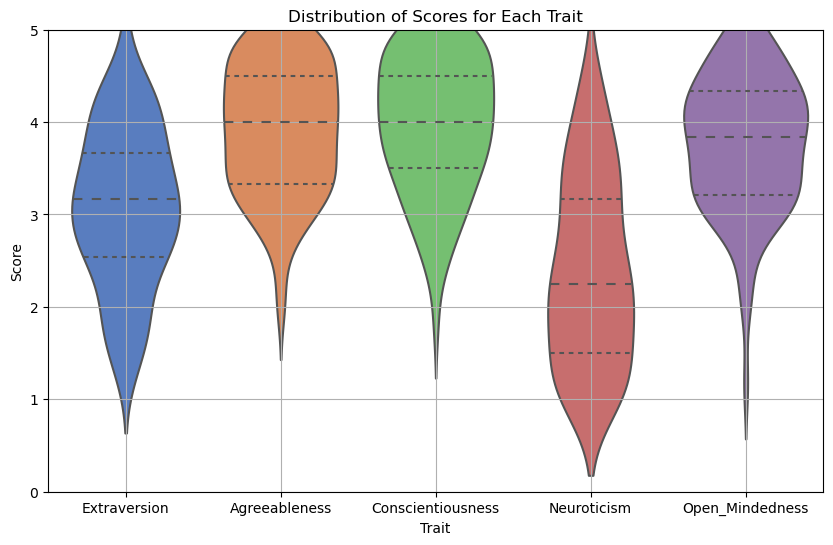

In [30]:
# Melt the DataFrame
big5_df_num = big5_df.iloc[:,1:]
big5_df_melted = big5_df_num.melt(var_name='Trait', value_name='Score')

# Create a violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='Trait', y='Score', data=big5_df_melted, inner='quartile', palette='muted')
plt.title('Distribution of Scores for Each Trait')
plt.ylim(0, 5)
plt.xlabel('Trait')
plt.ylabel('Score')
plt.grid(True)

# Show the plot
plt.show()

# generating distance_df for mixed personality trait

In [33]:
# Extract rows where all Big 5 scores are greater than 3
big5_df_high_scorers = big5_df[
                               (big5_df['Extraversion'] > 3) & 
                               (big5_df['Agreeableness'] > 3) & 
                               (big5_df['Conscientiousness'] > 3) & 
                               (big5_df['Open_Mindedness'] > 3)
]

# Display the result
print(f"Number of participants with targeted Big 5 scores > 3: {len(big5_df_high_scorers)}")
#print(big5_df_high_scorers)

Number of participants with targeted Big 5 scores > 3: 32


In [42]:
# Extract rows where all Big 5 scores are greater than 3
big5_df_ex_high_scorers = big5_df[big5_df['Extraversion'] > 3]['ResponseId'].tolist()
big5_df_ag_high_scorers = big5_df[big5_df['Agreeableness'] > 3]['ResponseId'].tolist()
big5_df_co_high_scorers = big5_df[big5_df['Conscientiousness'] > 3]['ResponseId'].tolist()
big5_df_op_high_scorers = big5_df[big5_df['Open_Mindedness'] > 3]['ResponseId'].tolist()

# Display the result
print(f"Number of participants with op > 3: {len(big5_df_op_high_scorers)}")
print(f"Number of participants with co > 3: {len(big5_df_co_high_scorers)}")
print(f"Number of participants with ex > 3: {len(big5_df_ex_high_scorers)}")
print(f"Number of participants with ag > 3: {len(big5_df_ag_high_scorers)}")

big5_dfs_dict = {}
big5_dfs_dict['op'] = big5_df[big5_df['ResponseId'].isin(big5_df_op_high_scorers)]
big5_dfs_dict['co'] = big5_df[big5_df['ResponseId'].isin(big5_df_co_high_scorers)]
big5_dfs_dict['ex'] = big5_df[big5_df['ResponseId'].isin(big5_df_ex_high_scorers)]
big5_dfs_dict['ag'] = big5_df[big5_df['ResponseId'].isin(big5_df_ag_high_scorers)]

Number of participants with op > 3: 75
Number of participants with co > 3: 77
Number of participants with ex > 3: 46
Number of participants with ag > 3: 79


In [38]:
socioecono_df_high_op = socioecono_df[socioecono_df['ResponseId'].isin(big5_df_op_high_scorers)]
socioecono_df_high_co = socioecono_df[socioecono_df['ResponseId'].isin(big5_df_co_high_scorers)]
socioecono_df_high_ex = socioecono_df[socioecono_df['ResponseId'].isin(big5_df_ex_high_scorers)]
socioecono_df_high_ag = socioecono_df[socioecono_df['ResponseId'].isin(big5_df_ag_high_scorers)]


print(f"OP: mean age {socioecono_df_high_op['age'].mean()} with sd {socioecono_df_high_op['age'].std()}, female % {socioecono_df_high_op[socioecono_df_high_op['gender']==1]['gender'].sum()/socioecono_df_high_op.shape[0]}")
print(f"CO: mean age {socioecono_df_high_co['age'].mean()} with sd {socioecono_df_high_co['age'].std()}, female % {socioecono_df_high_co[socioecono_df_high_co['gender']==1]['gender'].sum()/socioecono_df_high_co.shape[0]}")
print(f"EX: mean age {socioecono_df_high_ex['age'].mean()} with sd {socioecono_df_high_ex['age'].std()}, female % {socioecono_df_high_ex[socioecono_df_high_ex['gender']==1]['gender'].sum()/socioecono_df_high_ex.shape[0]}")
print(f"AG: mean age {socioecono_df_high_ag['age'].mean()} with sd {socioecono_df_high_ag['age'].std()}, female % {socioecono_df_high_ag[socioecono_df_high_ag['gender']==1]['gender'].sum()/socioecono_df_high_ag.shape[0]}")

socioecono_dfs_dict = {}
socioecono_dfs_dict['op'] = socioecono_df_high_op
socioecono_dfs_dict['co'] = socioecono_df_high_co
socioecono_dfs_dict['ex'] = socioecono_df_high_ex
socioecono_dfs_dict['ag'] = socioecono_df_high_ag

OP: mean age 40.653333333333336 with sd 11.715655191946228, female % 0.44
CO: mean age 41.675324675324674 with sd 12.262954008379054, female % 0.4935064935064935
EX: mean age 41.608695652173914 with sd 11.408531429241043, female % 0.5652173913043478
AG: mean age 40.40506329113924 with sd 11.88461512201834, female % 0.46835443037974683


In [37]:
mixed_trait_scores = pd.read_csv('raw/mixed_trait_scores.csv')
mixed_trait_scores

,Extraversion,Agreeableness,Conscientiousness,Open_Mindedness
0,3.166667,4.0,4.0,3.833333


In [43]:
big5_dfs_dict['op']

,ResponseId,Extraversion,Agreeableness,Conscientiousness,Neuroticism,Open_Mindedness
1,641357b26802e397b5627d5e,3.833333,3.166667,4.166667,1.833333,4.166667
2,66294a585f1cf3fdaeb80120,4.166667,3.166667,4.666667,1.833333,3.166667
3,661571d6cc16ee34676734df,3.166667,3.333333,3.000000,4.000000,4.166667
4,6629f95a14b6006e6a4b0aef,3.000000,4.333333,3.500000,2.666667,4.166667
5,66463d8b1984a328f78252d7,3.166667,3.666667,2.333333,3.500000,5.000000
...,...,...,...,...,...,...
94,666667f3e900925d27fe40d7,1.833333,2.000000,2.666667,4.333333,4.666667
95,63c0e1b1ee5ca75f61e3b2e1,4.500000,3.333333,3.833333,1.500000,4.000000
96,5d4a6459061e2a000138bad3,3.666667,4.333333,4.666667,2.166667,5.000000
101,6601b51675d287d6a62f11c4,3.666667,4.833333,4.333333,1.166667,4.666667


In [44]:
big5_dict = {'op': 'Open_Mindedness',
             'co': 'Conscientiousness',
             'ex': 'Extraversion',
             'ag': 'Agreeableness'}
    




In [52]:
def calculate_distance(df, mixed_scores, trait):
    trait_full = big5_dict[trait]
    return np.abs(df[trait_full] - mixed_scores[trait_full].values[0])

big5_distance_dfs_dict = {}

for type, df in big5_dfs_dict.items():
    distances = pd.DataFrame(index=df.index)
    
    for trait in big5_dict.keys():
        distances[f'{trait}_distance'] = calculate_distance(df, mixed_trait_scores, trait)
    
    distances['total_distance'] = distances.sum(axis=1)
    
    # Create the new DataFrame with distances and ResponseId
    big5_distance_df = pd.concat([df['ResponseId'], distances], axis=1)
    
    # Save the new DataFrame to the dictionary
    big5_distance_dfs_dict[type] = big5_distance_df
    
    # Also save as a global variable
    globals()[f'big5_distance_{type}'] = big5_distance_df
    
    # Display summary statistics
    print(f"Summary for {type.upper()}:")
    print(big5_distance_df.describe())
    print("\n")
    
    # Display top 5 closest participants based on total distance
    print(f"Top 5 closest participants for {type.upper()} based on total distance:")
    print(big5_distance_df.sort_values('total_distance').head())
    print("\n" + "="*50 + "\n")

Summary for OP:
       op_distance  co_distance  ex_distance  ag_distance  total_distance
count    75.000000    75.000000    75.000000    75.000000       75.000000
mean      0.466667     0.600000     0.682222     0.582222        2.331111
std       0.305112     0.427121     0.494848     0.400238        0.944596
min       0.000000     0.000000     0.000000     0.000000        0.500000
25%       0.166667     0.333333     0.333333     0.333333        1.750000
50%       0.500000     0.500000     0.500000     0.666667        2.166667
75%       0.666667     0.833333     1.000000     0.833333        3.000000
max       1.166667     2.166667     1.833333     2.000000        5.500000


Top 5 closest participants for OP based on total distance:
                  ResponseId  op_distance  co_distance  ex_distance  \
80  6665899df8740e0a2b6798fa     0.000000     0.000000     0.166667   
22  663192b96ab56cf1635615b7     0.000000     0.166667     0.666667   
10  661f1144d35ac5240e53ad3f     0.166667   

In [54]:
for key, value in big5_distance_dfs_dict.items():
    print(key)
    print(value.head())
    print("")

op
                 ResponseId  op_distance  co_distance  ex_distance  \
1  641357b26802e397b5627d5e     0.333333     0.166667     0.666667   
2  66294a585f1cf3fdaeb80120     0.666667     0.666667     1.000000   
3  661571d6cc16ee34676734df     0.333333     1.000000     0.000000   
4  6629f95a14b6006e6a4b0aef     0.333333     0.500000     0.166667   
5  66463d8b1984a328f78252d7     1.166667     1.666667     0.000000   

   ag_distance  total_distance  
1     0.833333        2.000000  
2     0.833333        3.166667  
3     0.666667        2.000000  
4     0.333333        1.333333  
5     0.333333        3.166667  

co
                 ResponseId  op_distance  co_distance  ex_distance  \
1  641357b26802e397b5627d5e     0.333333     0.166667     0.666667   
2  66294a585f1cf3fdaeb80120     0.666667     0.666667     1.000000   
4  6629f95a14b6006e6a4b0aef     0.333333     0.500000     0.166667   
6  5d215a1bbf7f840019701939     0.833333     0.166667     0.000000   
8  6601c47dbc5b1b7c9f1b3